# Gaussian mixture model for motion artifact classification

Uses unsupervised clustering to distinguish between clean signals and motion artifact-contaminated signals.
Original data are collected simultaneously from 4 blood pressure sensors and an accelerometer.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.signal as signal
import datetime

%matplotlib notebook

## Functions to be used for pre-processing and feature engineering

In [2]:
def dc_offset_correction(signal):
    dc_offset = np.repeat(np.mean(signal),len(signal))
    return signal-dc_offset

In [3]:
def autocorr(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

In [4]:
def slope(x1, y1, x2, y2):
    return (y2-y1)/(x2-x1)

## Load data

In [5]:
# list all files in directory

files = !ls *xq*.csv

In [ ]:
# load one file

file_num = 0
data = pd.read_csv(files[file_num], usecols = ['#time', 'seq', 'c0','c1','c2','c3','imu_mag', 'user_id', 'mac_address', 'start_time', 'stop_time','note'])

In [7]:
# change unix time stamp to date time format

data['#time'] = [datetime.datetime.fromtimestamp(s/1000.0) for s in data['#time']]

## Correct for DC offset

In [8]:
data['c0'] = dc_offset_correction(data['c0'])
data['c1'] = dc_offset_correction(data['c1'])
data['c2'] = dc_offset_correction(data['c2'])
data['c3'] = dc_offset_correction(data['c3'])

## Remove segments of data without signal
In this example, the signal disappears at the end. We will only analyze the data prior to that.

<IPython.core.display.Javascript object>


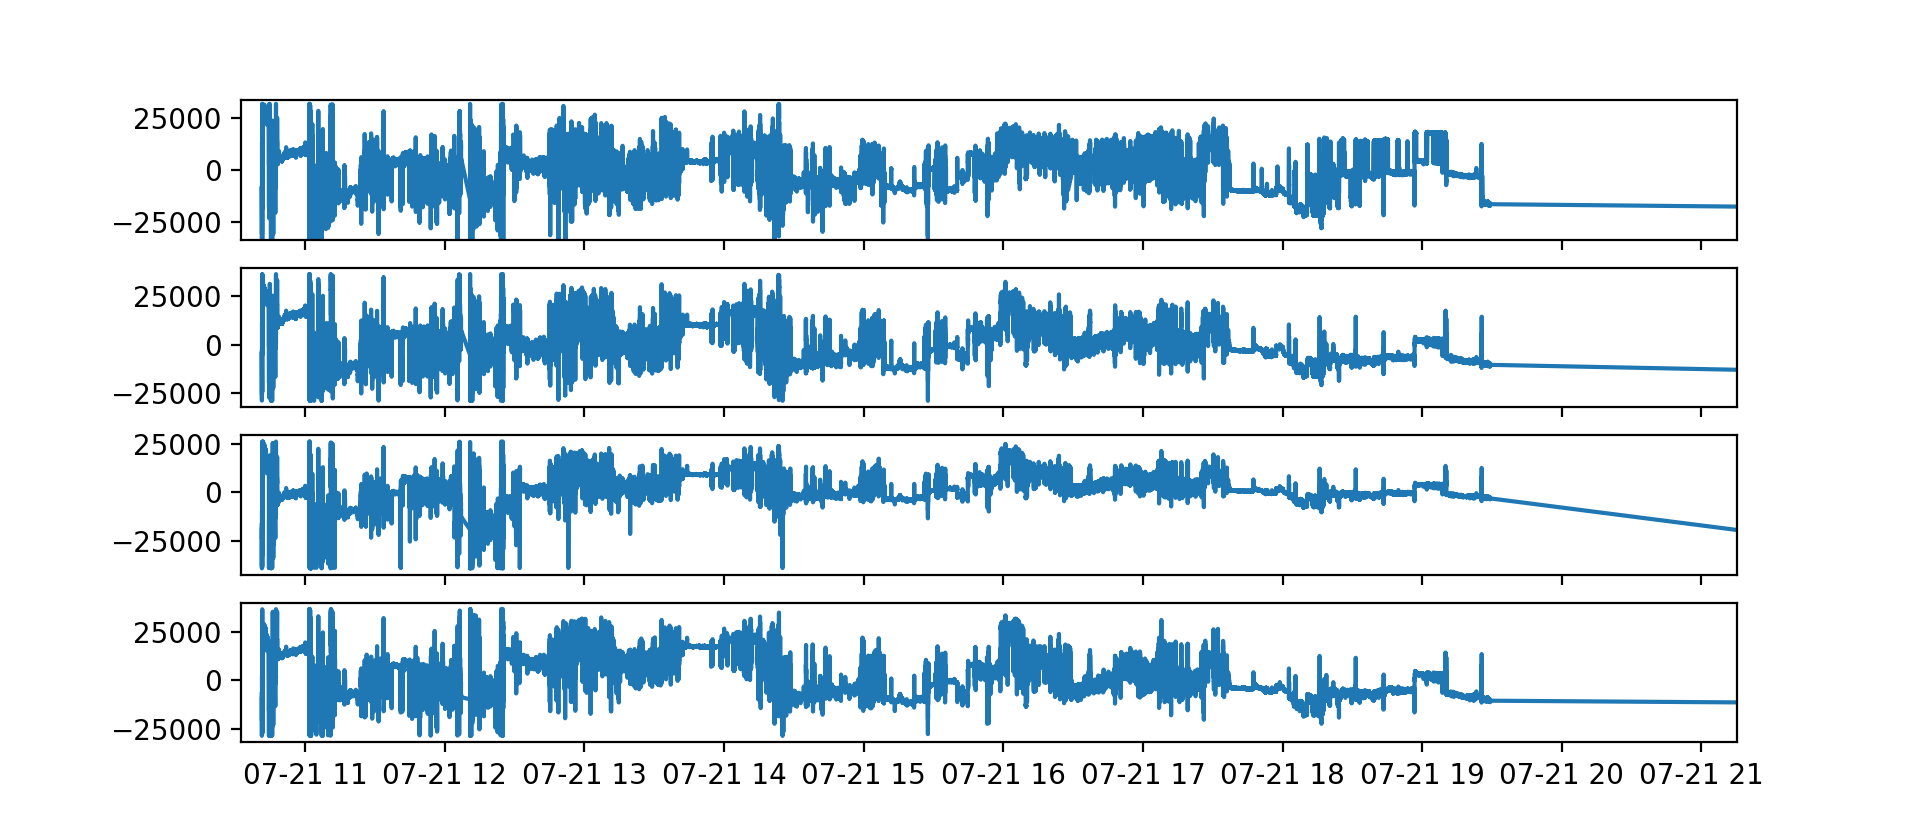

In [10]:
# plot raw sensor signals

from pandas.plotting import register_matplotlib_converters

fig_raw_sensor, axs = plt.subplots(4, 1, sharex=True)

axs[0].plot(data['#time'], data['c0'])
axs[1].plot(data['#time'], data['c1'])
axs[2].plot(data['#time'], data['c2'])
axs[3].plot(data['#time'], data['c3'])

In [11]:
# clean segments without data

new_data = data[data['#time'] < datetime.datetime(2019,7,21,19,10)]

<IPython.core.display.Javascript object>


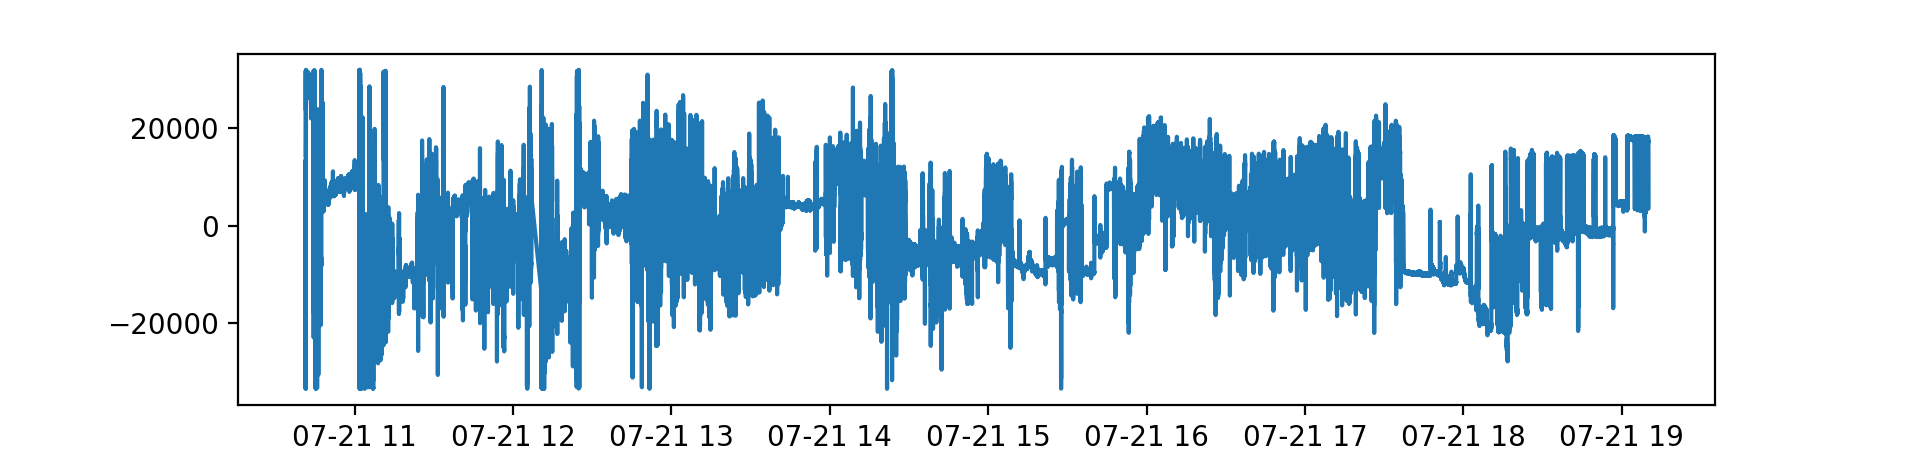

In [12]:
# plot cleaned data

fig, ax = plt.subplots()
ax.plot(new_data['#time'],new_data['c0'])

In [13]:
# duration of data segment

new_data['#time'].iloc[-1] - new_data['#time'].iloc[0]

Timedelta('0 days 08:28:38.129000')

## PCA on 4 sensor signals
Visually, you can see that the signals collected from the 4 sensors are very similar. PCA can reduce the dimensionality.

In [14]:
# PCA on 4 signals

from sklearn.decomposition import PCA

pca = PCA()
pca_model = pca.fit_transform(new_data[['c0', 'c1', 'c2', 'c3']]) # reconstruct signals
pca_signal_recon = pca_model.T[0,:]

<IPython.core.display.Javascript object>


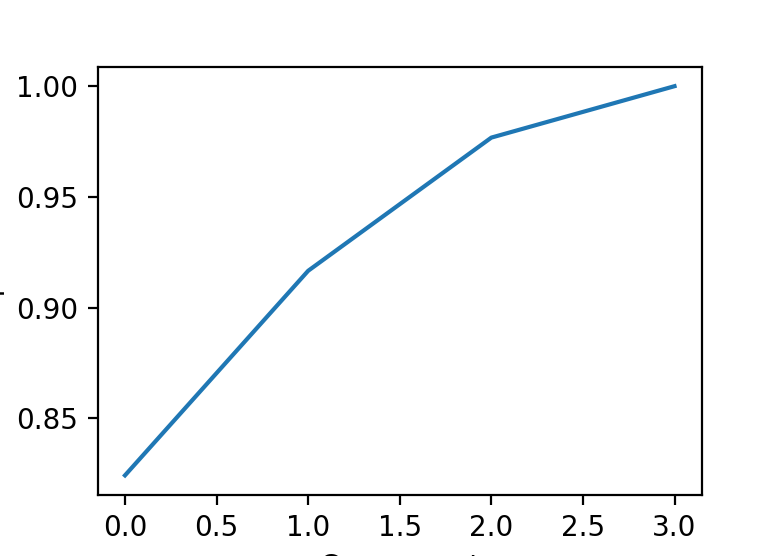

In [15]:
# PCA scree plot

pca_fit = pca.fit(new_data[['c0', 'c1', 'c2', 'c3']])
pca_explained_var = pca_fit.explained_variance_ratio_

fig, ax = plt.subplots()
ax.plot(np.cumsum(pca_explained_var))
plt.xlabel('Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

<IPython.core.display.Javascript object>


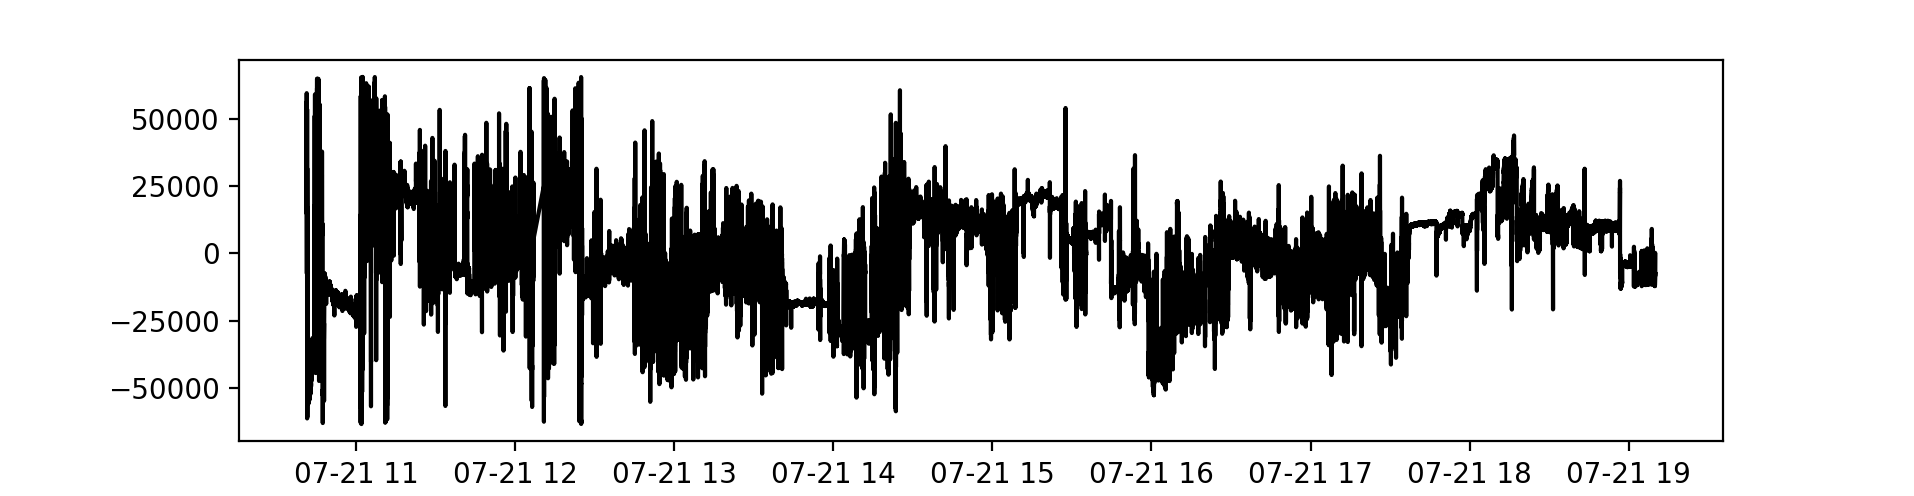

In [16]:
# plot PCA recovered signal

plt.figure()
plt.plot(new_data['#time'], pca_signal_recon, color='black')

## Initialize binning parameters, calculate features per epoch

In [17]:
# calculate sampling rate

seq_int = data['seq'].diff() # change in seq number
seq_breaks = np.where(seq_int < 1) # indices where change was neg
seq_breaks = seq_breaks[0]-1

if len(seq_breaks) == 0: # if no sequence breaks, fs = total samples / total seconds
    fs = len(data['#time']) / datetime.timedelta.total_seconds(data['#time'].iloc[-1] - data['#time'].iloc[0])
else: # if sequence breaks, fs = samples until first break / seconds until first break
    fs = (seq_breaks[0]) / datetime.timedelta.total_seconds(data['#time'].iloc[seq_breaks[0]] - data['#time'].iloc[0])

fs = (seq_breaks[0]-1) / datetime.timedelta.total_seconds(data['#time'].iloc[seq_breaks[0]] - data['#time'].iloc[0])

fs=int(fs)

In [18]:
# window characteristics and features

bin_time = 10 # time in seconds per bin
bin_samples = 10 * fs # number of samples per bin
total_num_bins = int(len(new_data['#time'])/bin_samples)
bin_counter = np.arange(0,total_num_bins)

bin_mean = []
bin_max = []
bin_min = []
bin_var = []
bin_range = []
bin_autocorr = []
bin_signal_1to3hz_pwr_mean = []
bin_signal_10to50hz_pwr_mean = []
bin_signal_1to3hz_pwr_var = []
bin_signal_10to50hz_pwr_var = []
bin_signal_1to3hz_pwr_min = []
bin_signal_10to50hz_pwr_min = []
bin_signal_1to3hz_pwr_max = []
bin_signal_10to50hz_pwr_max = []
bin_signal_1to3hz_pwr_range = []
bin_signal_10to50hz_pwr_range = []
bin_signal_accel_corr = []
bin_slope_mean = []
bin_slope_var = []
bin_slope_max = []
bin_slope_min = []
bin_slope_range = []

In [19]:
# calculate features for each epoch in PC single

for bin_current in bin_counter:
    window_start_idx = bin_current * bin_samples
    window_stop_idx = window_start_idx + bin_samples    
    data_in_window = np.array(pca_signal_recon[window_start_idx:window_stop_idx])
    accel_in_window = np.array(new_data['imu_mag'].iloc[window_start_idx:window_stop_idx])
    
    # signal statistical metrics
    bin_mean.append(np.mean(data_in_window))    
    bin_max.append(np.max(data_in_window))
    bin_min.append(np.min(data_in_window))
    bin_var.append(np.var(data_in_window))
    bin_range.append(np.ptp(data_in_window))
    
    # signal spectral metrics
    pwelch_window = 240 
    overlap = int(pwelch_window/2)
    f, bin_psd = signal.welch(data_in_window, fs, nperseg=pwelch_window, noverlap=overlap)
    bin_signal_1to3hz_pwr_mean.append(np.mean(bin_psd[np.logical_and(f>=1, f<=3)]))
    bin_signal_10to50hz_pwr_mean.append(np.mean(bin_psd[np.logical_and(f>=10, f<=50)]))
    bin_signal_1to3hz_pwr_var.append(np.var(bin_psd[np.logical_and(f>=1, f<=3)]))
    bin_signal_10to50hz_pwr_var.append(np.var(bin_psd[np.logical_and(f>=10, f<=50)]))
    bin_signal_1to3hz_pwr_min.append(np.min(bin_psd[np.logical_and(f>=1, f<=3)]))
    bin_signal_10to50hz_pwr_min.append(np.min(bin_psd[np.logical_and(f>=10, f<=50)]))
    bin_signal_1to3hz_pwr_max.append(np.max(bin_psd[np.logical_and(f>=1, f<=3)]))
    bin_signal_10to50hz_pwr_max.append(np.max(bin_psd[np.logical_and(f>=10, f<=50)]))
    bin_signal_1to3hz_pwr_range.append(np.ptp(bin_psd[np.logical_and(f>=1, f<=3)]))
    bin_signal_10to50hz_pwr_range.append(np.ptp(bin_psd[np.logical_and(f>=10, f<=50)]))

    # signal autocorrelation
    bin_autocorr.append(np.mean(abs(autocorr(data_in_window))))
    
    # signal correlation with accel
    bin_signal_accel_corr.append(np.corrcoef(data_in_window,accel_in_window)[0,1])    
    

    # signal slope
    pt_slope = []
    for pt in np.arange(0,len(data_in_window)-1,2):
        pt_slope.append(slope(0,data_in_window[pt],1,data_in_window[pt+1]))
    bin_slope_mean.append(np.mean(pt_slope))
    bin_slope_var.append(np.var(pt_slope))
    bin_slope_max.append(np.max(pt_slope))
    bin_slope_min.append(np.min(pt_slope))
    bin_slope_range.append(np.ptp(pt_slope))

## Select features for clustering and normalize

In [20]:
# select features
data_to_fit = [bin_mean, bin_max, bin_min, bin_var, bin_range, bin_autocorr, \
               bin_signal_1to3hz_pwr_mean, bin_signal_10to50hz_pwr_mean, \
               bin_signal_1to3hz_pwr_var, bin_signal_10to50hz_pwr_var, \
               bin_signal_1to3hz_pwr_min, bin_signal_10to50hz_pwr_min, \
               bin_signal_1to3hz_pwr_max, bin_signal_10to50hz_pwr_max, \
               bin_signal_1to3hz_pwr_range, bin_signal_10to50hz_pwr_range, \
               bin_signal_accel_corr, bin_slope_mean, bin_slope_var, \
               bin_slope_max, bin_slope_min, bin_slope_range]

data_to_fit = np.transpose(data_to_fit)

In [21]:
# normalize features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_data_to_fit = scaler.fit_transform(data_to_fit)

<IPython.core.display.Javascript object>


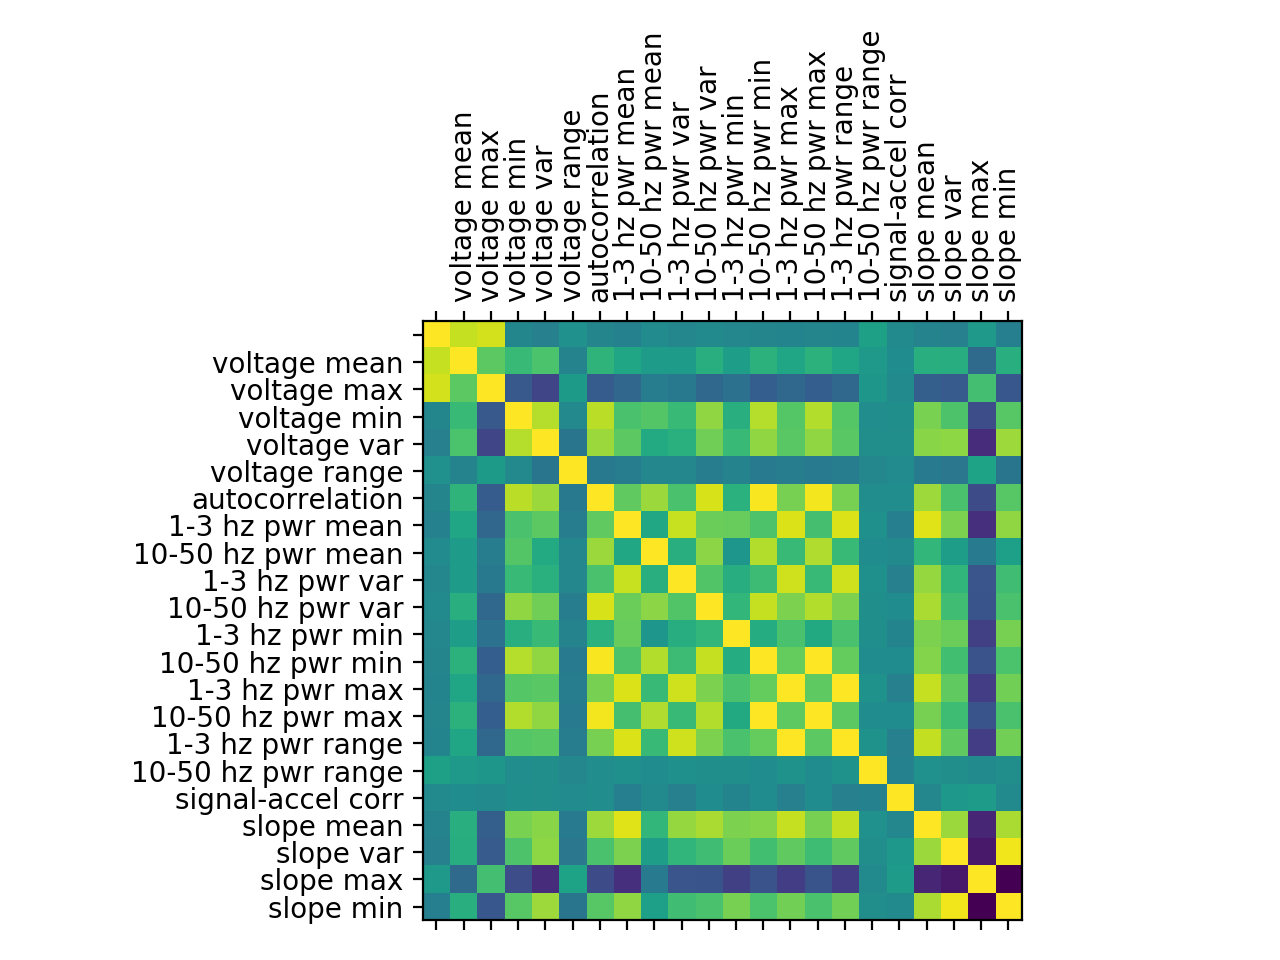

In [22]:
# correlation matrix of features

df_norm_data_to_fit = pd.DataFrame(norm_data_to_fit)
df_norm_data_to_fit.corr()

alpha = ['voltage mean', 'voltage max', 'voltage min', 'voltage var', 'voltage range', \
         'autocorrelation',\
        '1-3 hz pwr mean', '10-50 hz pwr mean', '1-3 hz pwr var', '10-50 hz pwr var',\
        '1-3 hz pwr min', '10-50 hz pwr min', '1-3 hz pwr max', '10-50 hz pwr max',\
        '1-3 hz pwr range', '10-50 hz pwr range', \
        'signal-accel corr','slope mean','slope var','slope max','slope min','slope range']

fig, ax = plt.subplots()
ax.matshow(df_norm_data_to_fit.corr())
plt.xticks(range(len(df_norm_data_to_fit.corr())), df_norm_data_to_fit.corr())
plt.yticks(range(len(df_norm_data_to_fit.corr())), df_norm_data_to_fit.corr())
ax.set_xticklabels([''] + alpha, rotation='vertical')
ax.set_yticklabels([''] + alpha)
plt.tight_layout()

## Visualize data in feature-PCA space

In [23]:
# PCA on feature space

from sklearn.decomposition import PCA

pca = PCA()
pca_features_model = pca.fit_transform(norm_data_to_fit) # reconstruct signals
pca_fit = pca.fit(norm_data_to_fit)
pca_explained_var = pca.explained_variance_ratio_

<IPython.core.display.Javascript object>


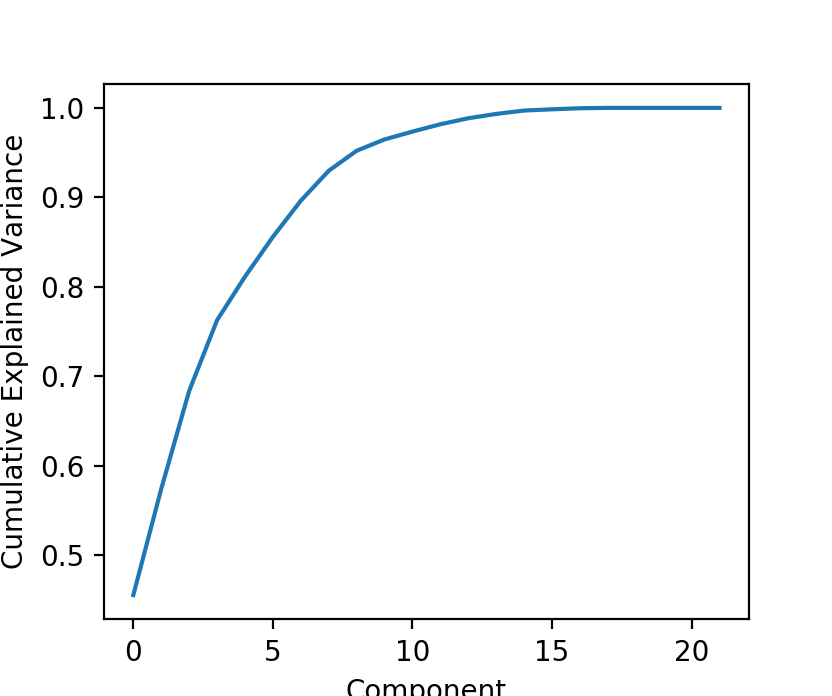

In [24]:
# PCA scree plot

fig,ax = plt.subplots()
ax.plot(np.cumsum(pca_explained_var))
plt.xlabel('Component')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [25]:
num_components = 5 # explained ~90% of variance
norm_data_to_fit_pca = pca_features_model.T[:num_components,:]
norm_data_to_fit_pca = np.transpose(norm_data_to_fit_pca)

<IPython.core.display.Javascript object>


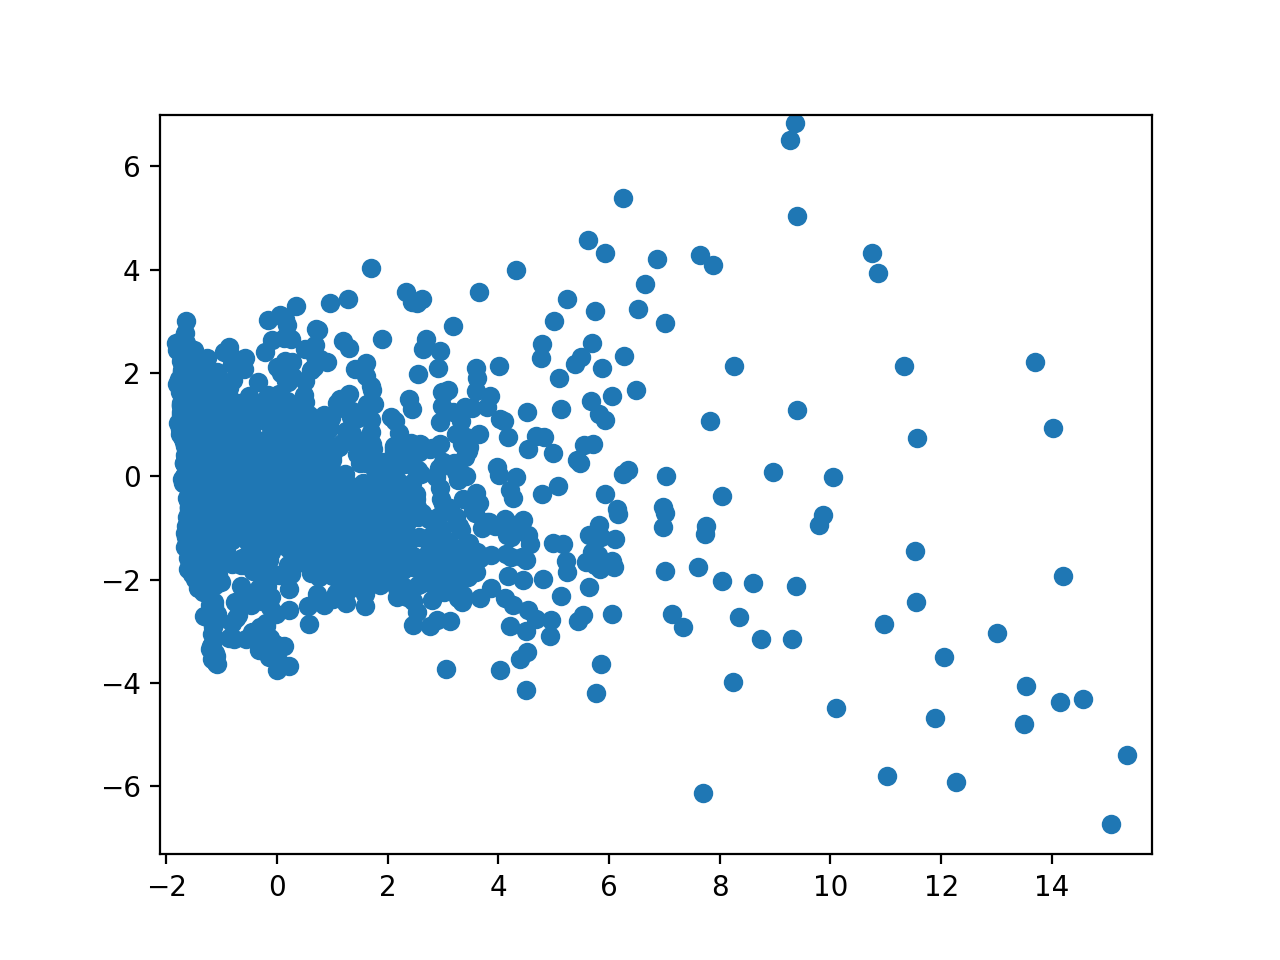

In [26]:
# 2d scatter plot

ft_num = [0,1] # select which features to look at

fig_2d, ax_2d = plt.subplots()
ax_2d.scatter(pca_features_model.T[ft_num[0],:], pca_features_model.T[ft_num[1],:])

## Clustering on PCA features

<IPython.core.display.Javascript object>


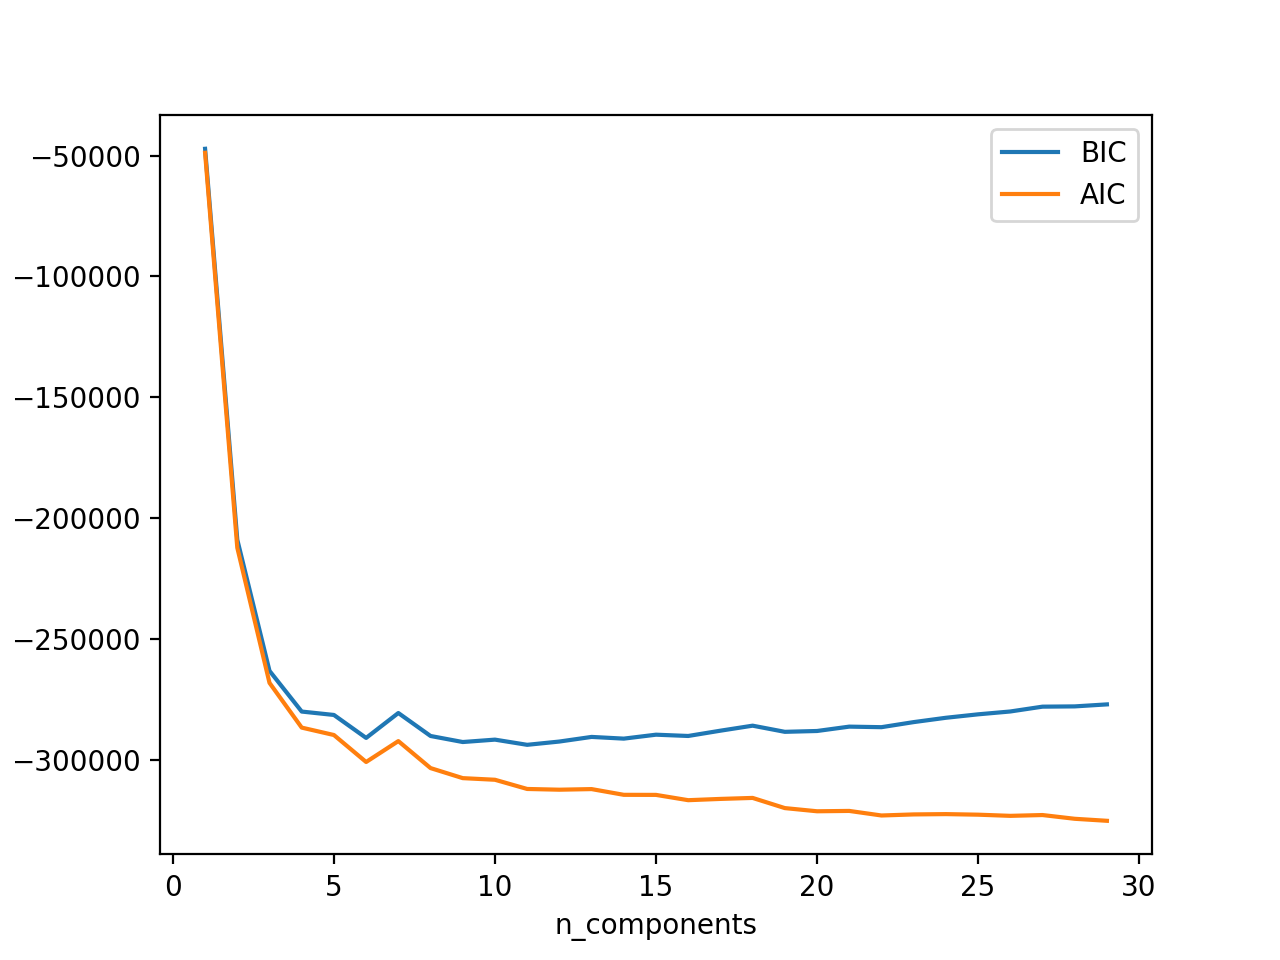

In [27]:
# plot AIC, BIC

from sklearn import mixture

n_components = np.arange(1, 30)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(norm_data_to_fit) for n in n_components]

fig, ax = plt.subplots()
ax.plot(n_components, [m.bic(norm_data_to_fit) for m in models], label='BIC')
ax.plot(n_components, [m.aic(norm_data_to_fit) for m in models], label='AIC')
ax.legend(loc='best')
plt.xlabel('n_components');

<IPython.core.display.Javascript object>


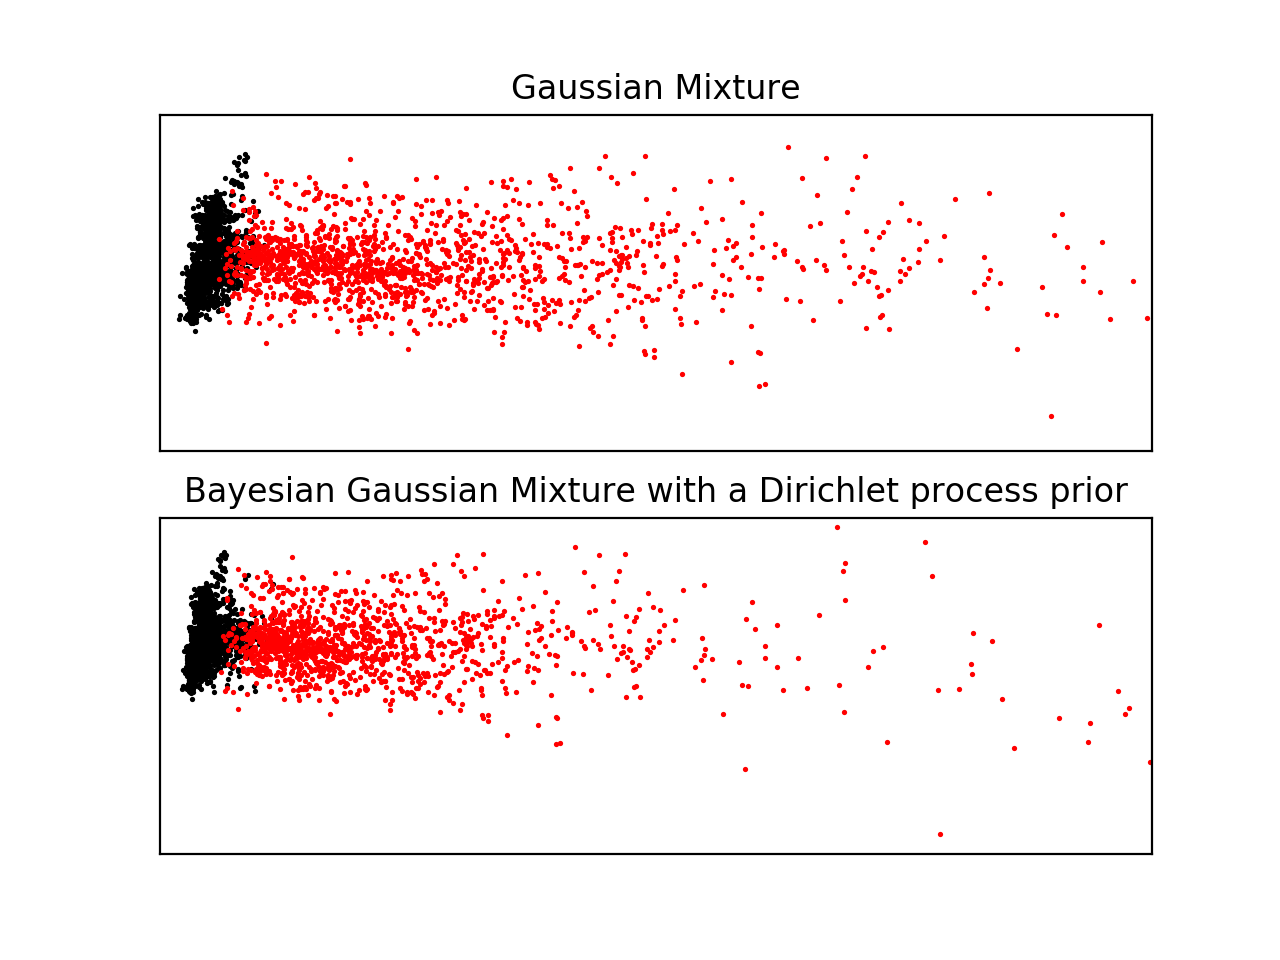

In [28]:
# clustering with guassian mixture model

import itertools
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(['black', 'red'])

fig, ax = plt.subplots()

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 2], .8, color=color)

#         # Plot an ellipse to show the Gaussian component
#         angle = np.arctan(u[1] / u[0])
#         angle = 180. * angle / np.pi  # convert to degrees
#         ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
#         ell.set_clip_box(splot.bbox)
#         ell.set_alpha(0.5)
#         splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(norm_data_to_fit_pca)
plot_results(norm_data_to_fit_pca, gmm.predict(norm_data_to_fit_pca), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=2, covariance_type='full').fit(norm_data_to_fit_pca)
plot_results(norm_data_to_fit_pca, dpgmm.predict(norm_data_to_fit_pca), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

In [29]:
labels = dpgmm.predict(norm_data_to_fit_pca)
print(sum(labels==1))
print(sum(labels==0))

1314
1707


<IPython.core.display.Javascript object>


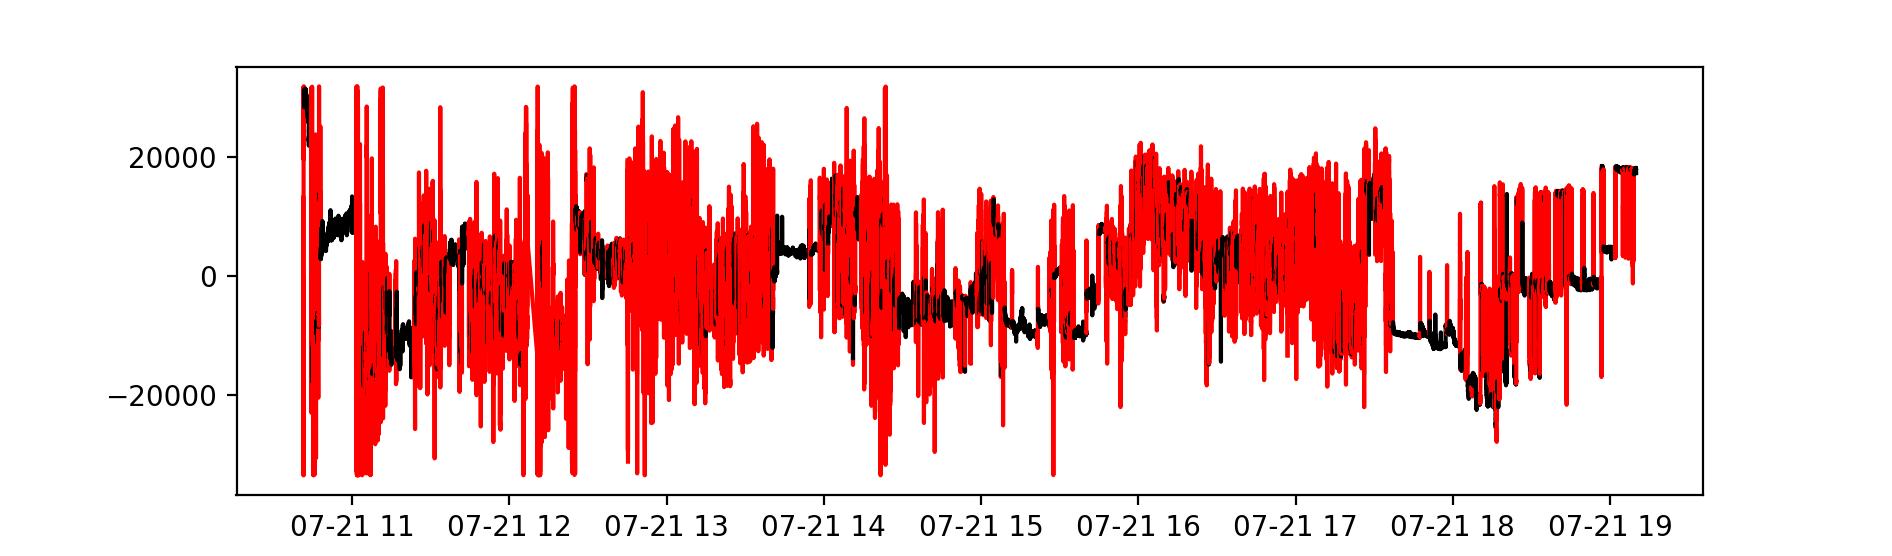

In [30]:
# project clusters back into time space

fig_sig_km, ax_sig_km = plt.subplots()
ax_sig_km.plot()


for bin_current in bin_counter:
    window_start_idx = bin_current * bin_samples
    window_stop_idx = window_start_idx + bin_samples
    
    plot_time = data['#time'].iloc[window_start_idx:window_stop_idx]
    
    if labels[bin_current] == 0:
        sig_color = 'black'
    elif labels[bin_current] == 1:
        sig_color = 'red'
    elif labels[bin_current] == 2:
        sig_color = 'blue'
    elif labels[bin_current] == 3:
        sig_color = 'yellow'    
        
    ax_sig_km.plot(plot_time,new_data['c0'].iloc[window_start_idx:window_stop_idx],color=sig_color)

## Validate clustering by looking at distributions of QA scores

In [31]:
# average qa score across 4 signals

qa_mean = data[['user_id','mac_address','start_time','stop_time']].mean(axis=1)

In [32]:
# interpolate QA score

qa = qa_mean.dropna()
new_qa = []
qa_extrap = []
for i in qa.keys():
    new_qa.append(qa[i])
    
new_qa
qa_extrap.append(np.repeat(new_qa, 11)) # 11 samples separate the QA scores
qa_extrap = qa_extrap[0]

start_qa = list(np.repeat(np.nan, 277)) # first QA score starts at 278
FINAL_QA = start_qa + list(qa_extrap)

In [33]:
# quantify avg QA score per bin

cluster0_qa = []
cluster1_qa = []

for bin_current in bin_counter:
    temp=[]
    window_start_idx = bin_current * bin_samples
    window_stop_idx = window_start_idx + bin_samples
        
    if labels[bin_current] == 0:
        temp = np.mean(np.abs(data['user_id'].iloc[window_start_idx:window_stop_idx]))
        cluster0_qa.append(temp)
    elif labels[bin_current] == 1:
        temp = np.mean(np.abs(data['user_id'].iloc[window_start_idx:window_stop_idx]))
        cluster1_qa.append(temp)

<IPython.core.display.Javascript object>


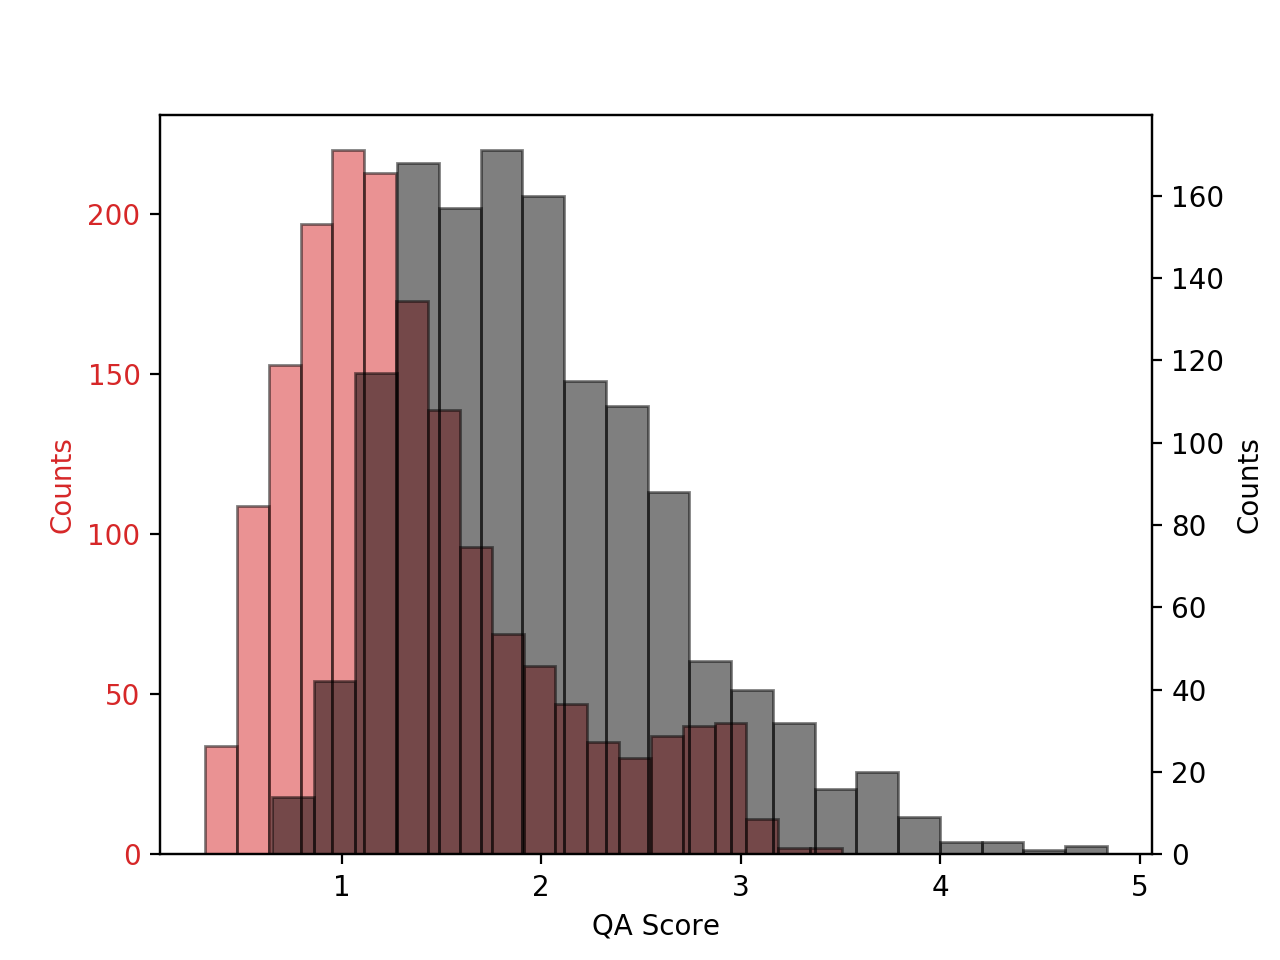

1.216976315789473
1.8919311403508772
1.891869260783646e-139
3.4561219058527295e-144


In [35]:
# histogram of qa scores for cluster 0 and cluster 1

from scipy.stats import ranksums
from scipy.stats import ttest_ind
import seaborn as sns

cluster0_qa = np.array(cluster0_qa)
cluster1_qa = np.array(cluster1_qa)

fig, ax = plt.subplots()

color = 'tab:red'
ax.set_xlabel('QA Score')
ax.set_ylabel('Counts', color=color)
ax.hist(cluster0_qa, 20, color=color, label='Cluster 0', edgecolor='black', lw=1, alpha = 0.5)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'black'
ax2.set_ylabel('Counts',color=color)  # we already handled the x-label with ax1
ax2.hist(cluster1_qa, 20, color=color, label='Cluster 1', edgecolor='black', lw=1, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color)


t,pt = ttest_ind(cluster0_qa,cluster1_qa)
w,pw = ranksums(cluster0_qa, cluster1_qa)

print(np.nanmedian(cluster0_qa))
print(np.nanmedian(cluster1_qa))
print(pt)
print(pw)